***Packages Importing/Installing***

In [117]:
# 1. External Installations
!pip install prince

# 2. Standard Libraries
import os
import math

# 3. Data Manipulation and Analysis
import numpy as np
import pandas as pd
import kagglehub
import prince

# 4. Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# 5. Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import IsolationForest

# Imputation
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Clustering & Metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

***Fetching the Dataset***

In [118]:
path = kagglehub.dataset_download("ysthehurricane/podcast-listening-time-prediction-dataset")

csv_path = os.path.join(path, "podcast_dataset.csv")
df = pd.read_csv(csv_path)

Using Colab cache for faster access to the 'podcast-listening-time-prediction-dataset' dataset.


# **Dataset Overview**

In [119]:
df.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,Healthy Living,Episode 77,99.25,Health,21.37,Thursday,Night,70.22,3,Positive,55.158695
1,Mystery Matters,Episode 6,19.43,True Crime,47.19,Friday,Evening,75.15,1,Neutral,7.686559
2,Current Affairs,Episode 1,117.03,News,96.33,Sunday,Night,57.95,3,Neutral,110.064645
3,Mystery Matters,Episode 38,16.97,True Crime,25.73,Monday,Night,24.19,0,Positive,12.000380
4,Humor Hub,Episode 73,83.48,Comedy,76.69,Tuesday,Afternoon,42.31,3,Positive,NaN


In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52500 entries, 0 to 52499
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Podcast_Name                 52500 non-null  object 
 1   Episode_Title                52500 non-null  object 
 2   Episode_Length_minutes       47254 non-null  float64
 3   Genre                        52500 non-null  object 
 4   Host_Popularity_percentage   52500 non-null  float64
 5   Publication_Day              52500 non-null  object 
 6   Publication_Time             52500 non-null  object 
 7   Guest_Popularity_percentage  47242 non-null  float64
 8   Number_of_Ads                52500 non-null  int64  
 9   Episode_Sentiment            52500 non-null  object 
 10  Listening_Time_minutes       47105 non-null  float64
dtypes: float64(4), int64(1), object(6)
memory usage: 4.4+ MB


In [121]:
df.describe()

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,47254.000000,52500.000000,47242.000000,52500.000000,47105.000000
mean,62.853491,60.163949,50.053434,1.497962,45.560293
std,33.137428,23.158567,28.884997,1.117412,27.182454
min,5.000000,20.000000,0.010000,0.000000,0.000000
25%,34.300000,40.000000,25.030000,0.000000,23.286442
50%,62.870000,60.300000,50.035000,1.000000,43.555490
75%,91.550000,80.310000,75.100000,2.000000,64.953793
max,120.000000,100.000000,100.000000,3.000000,119.970000


In [122]:
df.describe(include=['O'])

,Podcast_Name,Episode_Title,Genre,Publication_Day,Publication_Time,Episode_Sentiment
count,52500,52500,52500,52500,52500,52500
unique,48,100,10,7,4,3
top,Style Guide,Episode 61,Business,Saturday,Night,Positive
freq,1167,574,5559,7603,13316,17564


# **Data Cleaning**

***Data Formatting***

In [123]:
df.columns = df.columns.str.lower()

In [124]:
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = df[col].astype(str).str.lower().str.strip()

In [125]:
for col in cat_cols:
    unique_values = df[col].unique()
    print(f"\nVariable: {col}")
    print(f"Number of unique categories: {len(unique_values)}")
    print(f"Categories: {unique_values}")


Variable: podcast_name
Number of unique categories: 48
Categories: ['healthy living' 'mystery matters' 'current affairs' 'humor hub'
 'money matters' 'style guide' 'fitness first' 'tech talks' 'world watch'
 'joke junction' 'gadget geek' 'melody mix' 'finance focus' 'tune time'
 'innovators' 'mind & body' 'business insights' 'laugh line'
 'comedy corner' 'sports weekly' 'digital digest' 'learning lab'
 'news roundup' 'wellness wave' 'brain boost' 'detective diaries'
 'tech trends' "athlete's arena" 'daily digest' 'educational nuggets'
 'business briefs' 'sport spot' 'true crime stories' 'lifestyle lounge'
 'game day' 'health hour' 'study sessions' 'life lessons' 'home & living'
 'music matters' 'crime chronicles' 'sound waves' 'criminal minds'
 'fashion forward' 'market masters' 'global news' 'funny folks'
 'sports central']

Variable: episode_title
Number of unique categories: 100
Categories: ['episode 77' 'episode 6' 'episode 1' 'episode 38' 'episode 73'
 'episode 87' 'episode 76' '

***Handling Duplicates***

In [126]:
print(df.duplicated().sum())

2500


In [127]:
df.drop_duplicates(inplace=True)

In [128]:
print(df.duplicated().sum())

0


***Split the Dataset (Training: 80% , Testing: 20%)***

In [129]:
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['genre']
)

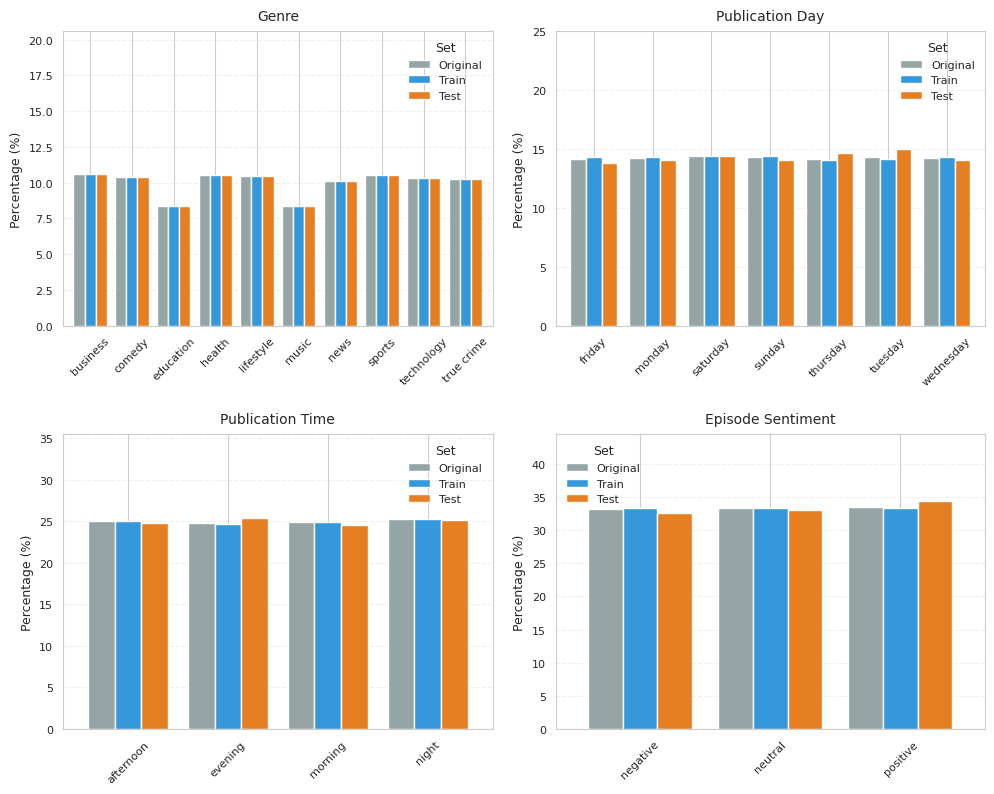

In [130]:
cat_cols = ['genre', 'publication_day', 'publication_time', 'episode_sentiment']

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

plt.rcParams.update({
    'font.size': 9,
    'axes.titlesize': 10,
    'axes.labelsize': 9,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8
})


colors = ['#95a5a6', '#3498db', '#e67e22']

for i, col in enumerate(cat_cols):
    original_percent = df[col].value_counts(normalize=True).sort_index() * 100
    train_percent = train_df[col].value_counts(normalize=True).sort_index() * 100
    test_percent = test_df[col].value_counts(normalize=True).sort_index() * 100

    compare_df = pd.DataFrame({
        'Original': original_percent,
        'Train': train_percent,
        'Test': test_percent
    }).fillna(0)

    compare_df.plot(kind='bar', ax=axes[i], width=0.8, color=colors)

    axes[i].set_title(f'{col.replace("_", " ").title()}', fontsize=10, pad=8)
    axes[i].set_ylabel('Percentage (%)', fontsize=9)
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend(title='Set', loc='best', frameon=False)
    axes[i].grid(axis='y', alpha=0.3, linestyle='--')
    axes[i].set_ylim(0, compare_df.max().max() + 10)

plt.tight_layout(pad=1.0, w_pad=1.5, h_pad=2.0)
plt.show()

In [131]:
df = train_df

***Handling Missing Values***

MICE (Multiple Imputation by Chained Equations) methods was used for this. (Used for only the correlated numerical columns)

In [132]:
missing_count = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_count, 'Percentage (%)': missing_percentage})

print(missing_df.sort_values(by='Percentage (%)', ascending=False))

                             Missing Values  Percentage (%)
listening_time_minutes                 4119         10.2975
episode_length_minutes                 4054         10.1350
guest_popularity_percentage            4025         10.0625
episode_title                             0          0.0000
podcast_name                              0          0.0000
genre                                     0          0.0000
host_popularity_percentage                0          0.0000
publication_time                          0          0.0000
publication_day                           0          0.0000
number_of_ads                             0          0.0000
episode_sentiment                         0          0.0000


In [133]:
mice_cols = ['listening_time_minutes', 'episode_length_minutes']

mice_imputer = IterativeImputer(max_iter=10, random_state=42)

df[mice_cols] = mice_imputer.fit_transform(df[mice_cols])

df.isnull().sum()

,0
podcast_name,0
episode_title,0
episode_length_minutes,0
genre,0
host_popularity_percentage,0
publication_day,0
publication_time,0
guest_popularity_percentage,4025
number_of_ads,0
episode_sentiment,0


In [134]:
knn_num_cols = [
    'listening_time_minutes',
    'episode_length_minutes',
    'host_popularity_percentage',
    'number_of_ads',
    'guest_popularity_percentage'
]

knn_cat_cols = [
    'podcast_name',
    'genre',
    'publication_day',
    'publication_time',
    'episode_sentiment'
]

df_num = df[knn_num_cols].copy()

scaler = StandardScaler()
df_num_scaled = pd.DataFrame(
    scaler.fit_transform(df_num),
    columns=knn_num_cols,
    index=df.index
)

df_cat_encoded = pd.get_dummies(
    df[knn_cat_cols],
    drop_first=True
)

df_knn_input = pd.concat(
    [df_num_scaled, df_cat_encoded],
    axis=1
)

knn_imputer = KNNImputer(n_neighbors=5)

df_knn_imputed = pd.DataFrame(
    knn_imputer.fit_transform(df_knn_input),
    columns=df_knn_input.columns,
    index=df.index
)

df_num_imputed = pd.DataFrame(
    scaler.inverse_transform(df_knn_imputed[knn_num_cols]),
    columns=knn_num_cols,
    index=df.index
)

df['guest_popularity_percentage'] = df_num_imputed['guest_popularity_percentage']

df.isnull().sum()

,0
podcast_name,0
episode_title,0
episode_length_minutes,0
genre,0
host_popularity_percentage,0
publication_day,0
publication_time,0
guest_popularity_percentage,0
number_of_ads,0
episode_sentiment,0


***Check for Outliers***

IQR and Isolation Forest was used.

In [135]:
#Univariate outliers

num_cols = ['episode_length_minutes', 'host_popularity_percentage',
            'guest_popularity_percentage', 'number_of_ads', 'listening_time_minutes']
outlier_summary = []
total_outlier_rows = set()

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR_val = Q3 - Q1
    lower = Q1 - 1.5 * IQR_val
    upper = Q3 + 1.5 * IQR_val

    outliers = df[(df[col] < lower) | (df[col] > upper)]
    count = len(outliers)
    percentage = (count / len(df)) * 100
    outlier_summary.append({'Variable': col, 'Outliers': count, 'Percentage': percentage})

    total_outlier_rows.update(outliers.index)

print("Univariate Outlier Summary:")
print(pd.DataFrame(outlier_summary))
print(f"\nTotal unique rows with at least one outlier: {len(total_outlier_rows)} ({len(total_outlier_rows)/len(df)*100:.2f}%)")

Univariate Outlier Summary:
                      Variable  Outliers  Percentage
0       episode_length_minutes         0         0.0
1   host_popularity_percentage         0         0.0
2  guest_popularity_percentage         0         0.0
3                number_of_ads         0         0.0
4       listening_time_minutes         0         0.0

Total unique rows with at least one outlier: 0 (0.00%)


In [136]:
#multivariate outliers
features = ['episode_length_minutes', 'host_popularity_percentage',
            'guest_popularity_percentage', 'number_of_ads', 'listening_time_minutes']

iso_forest = IsolationForest(contamination=0.05, random_state=42, n_estimators=100)
df['iso_anomaly'] = iso_forest.fit_predict(df[features])


outliers_multi = df[df['iso_anomaly'] == -1]
num_outliers = len(outliers_multi)
perc_outliers = (num_outliers / len(df)) * 100


summary_df = pd.DataFrame({
    'Variable': ['Multivariate (Isolation Forest)'],
    'Outliers': [num_outliers],
    'Percentage': [round(perc_outliers, 2)]
})

print("Multivariate Outlier Summary:")
print(summary_df.to_string(index=False))
print(f"\nTotal unique rows with multivariate outliers: {num_outliers} ({perc_outliers:.2f}%)")

Multivariate Outlier Summary:
                       Variable  Outliers  Percentage
Multivariate (Isolation Forest)      2000         5.0

Total unique rows with multivariate outliers: 2000 (5.00%)


# **Feature Engineering**

***Feature Extraction***

In [137]:
df['completion_rate'] = df['listening_time_minutes'] / df['episode_length_minutes']

In [138]:

df['length_category'] = pd.cut(df['episode_length_minutes'],
                                     bins=[0, 30, 60, 90, 120],
                                     labels=['Short (0-30m)', 'Medium (30-60m)', 'Long (60-90m)', 'Extra-Long (90m+)'])

In [139]:
df.head()

,podcast_name,episode_title,episode_length_minutes,genre,host_popularity_percentage,publication_day,publication_time,guest_popularity_percentage,number_of_ads,episode_sentiment,listening_time_minutes,iso_anomaly,completion_rate,length_category
29709,game day,episode 53,73.72,sports,92.25,sunday,night,52.230,2,positive,68.759789,1,0.932716,Long (60-90m)
34713,business insights,episode 40,76.55,business,51.94,monday,evening,68.802,0,positive,54.778963,1,0.715597,Long (60-90m)
15050,true crime stories,episode 54,44.32,true crime,31.93,saturday,evening,42.900,2,neutral,31.700944,1,0.715274,Medium (30-60m)
46443,gadget geek,episode 71,72.83,technology,34.16,sunday,night,40.586,2,negative,56.417005,1,0.774640,Long (60-90m)
1646,sport spot,episode 80,75.67,sports,99.48,tuesday,night,36.470,2,positive,63.167084,1,0.834770,Long (60-90m)


***Dimentionality Reduction***

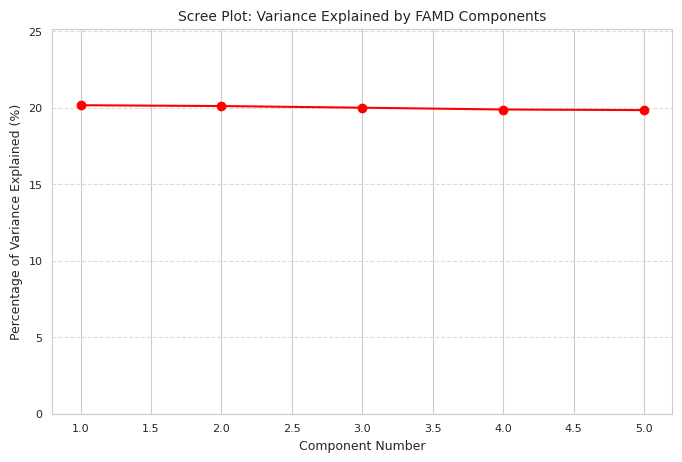

In [140]:
features = [
    'episode_length_minutes',
    'host_popularity_percentage',
    'guest_popularity_percentage',
    'number_of_ads',
    'publication_day',
    'publication_time',
    'genre',
    'episode_sentiment'
]


X = train_df[features]

famd = prince.FAMD(
    n_components=5,
    n_iter=3,
    copy=True,
    check_input=True,
    random_state=42
)

famd = famd.fit(X)

eigenvalues = famd.eigenvalues_
variance_explained = [x / sum(eigenvalues) * 100 for x in eigenvalues]

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(variance_explained) + 1), variance_explained, marker='o', color='red')
plt.title('Scree Plot: Variance Explained by FAMD Components')
plt.xlabel('Component Number')
plt.ylabel('Percentage of Variance Explained (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, max(variance_explained) + 5)
plt.show()

In [141]:
famd = prince.FAMD(
    n_components=2,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)


famd = famd.fit(X)
X_famd = famd.transform(X)

print("FAMD Transformation Complete!")
X_famd.head()

FAMD Transformation Complete!


component,0,1
29709,4.992000,-0.452999
34713,1.056634,1.432786
15050,-0.953025,2.369350
46443,2.826087,1.289073
1646,3.181193,-0.767073


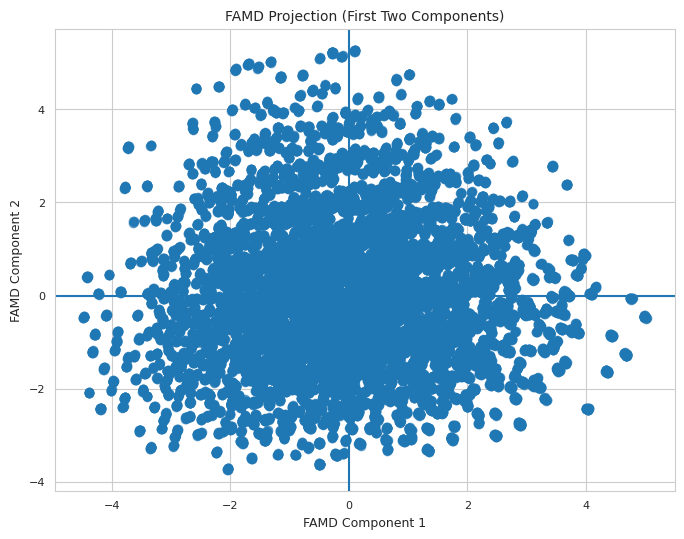

In [142]:
plt.figure(figsize=(8, 6))
plt.scatter(
    X_famd[0],
    X_famd[1],
    alpha=0.6
)

plt.xlabel("FAMD Component 1")
plt.ylabel("FAMD Component 2")
plt.title("FAMD Projection (First Two Components)")
plt.axhline(0)
plt.axvline(0)
plt.show()


In [143]:
var_contrib = famd.column_contributions_

var_contrib


component,0,1
variable,,
episode_length_minutes,0.000012,0.000018
host_popularity_percentage,0.000014,0.000001
guest_popularity_percentage,0.000007,0.000200
episode_sentiment,0.047201,0.008532
genre,0.128631,0.136179
number_of_ads,0.067774,0.030965
publication_day,0.087251,0.164408
publication_time,0.069280,0.059973


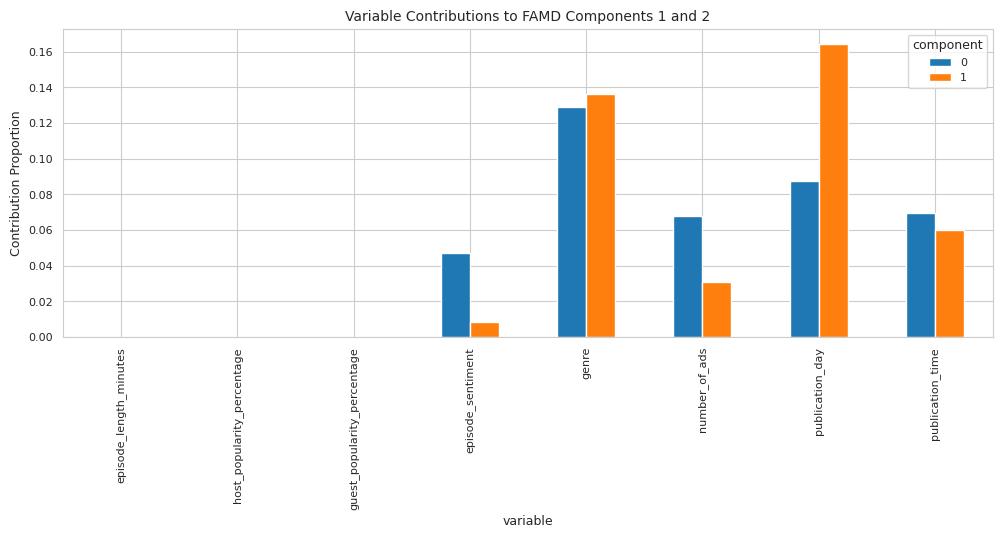

In [144]:
var_contrib[[0, 1]].plot.bar(
    figsize=(12, 4),
    title="Variable Contributions to FAMD Components 1 and 2"
)
plt.ylabel("Contribution Proportion")
plt.show()


***Cluster Analysis***

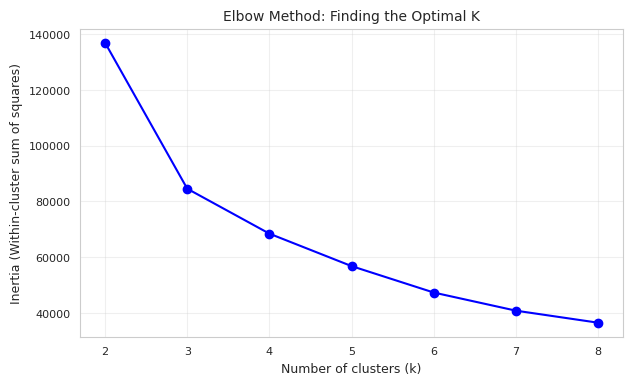

In [145]:
X = X_famd

Inertia = []
K_range = range(2, 9)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    Inertia.append(km.inertia_)

plt.figure(figsize=(7,4))
plt.plot(K_range, Inertia, marker='o', color='blue')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (Within-cluster sum of squares)")
plt.title("Elbow Method: Finding the Optimal K")
plt.grid(True, alpha=0.3)
plt.show()

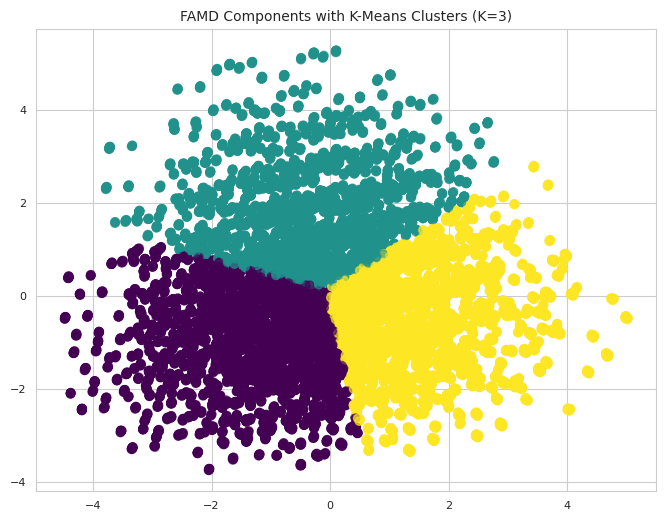

In [146]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)


clusters = kmeans.fit_predict(X_famd)


plt.figure(figsize=(8, 6))
plt.scatter(
    X_famd[0],
    X_famd[1],
    c=clusters,
    cmap='viridis',
    alpha=0.6
)
plt.title("FAMD Components with K-Means Clusters (K=3)")
plt.show()

In [147]:
X = X_famd


kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)


sil_score = silhouette_score(X, labels)
db_score = davies_bouldin_score(X_famd, labels)

print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies–Bouldin Score: {db_score:.3f}")

Silhouette Score: 0.361
Davies–Bouldin Score: 0.883


# **Exploratory Data Analysis**

/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector,

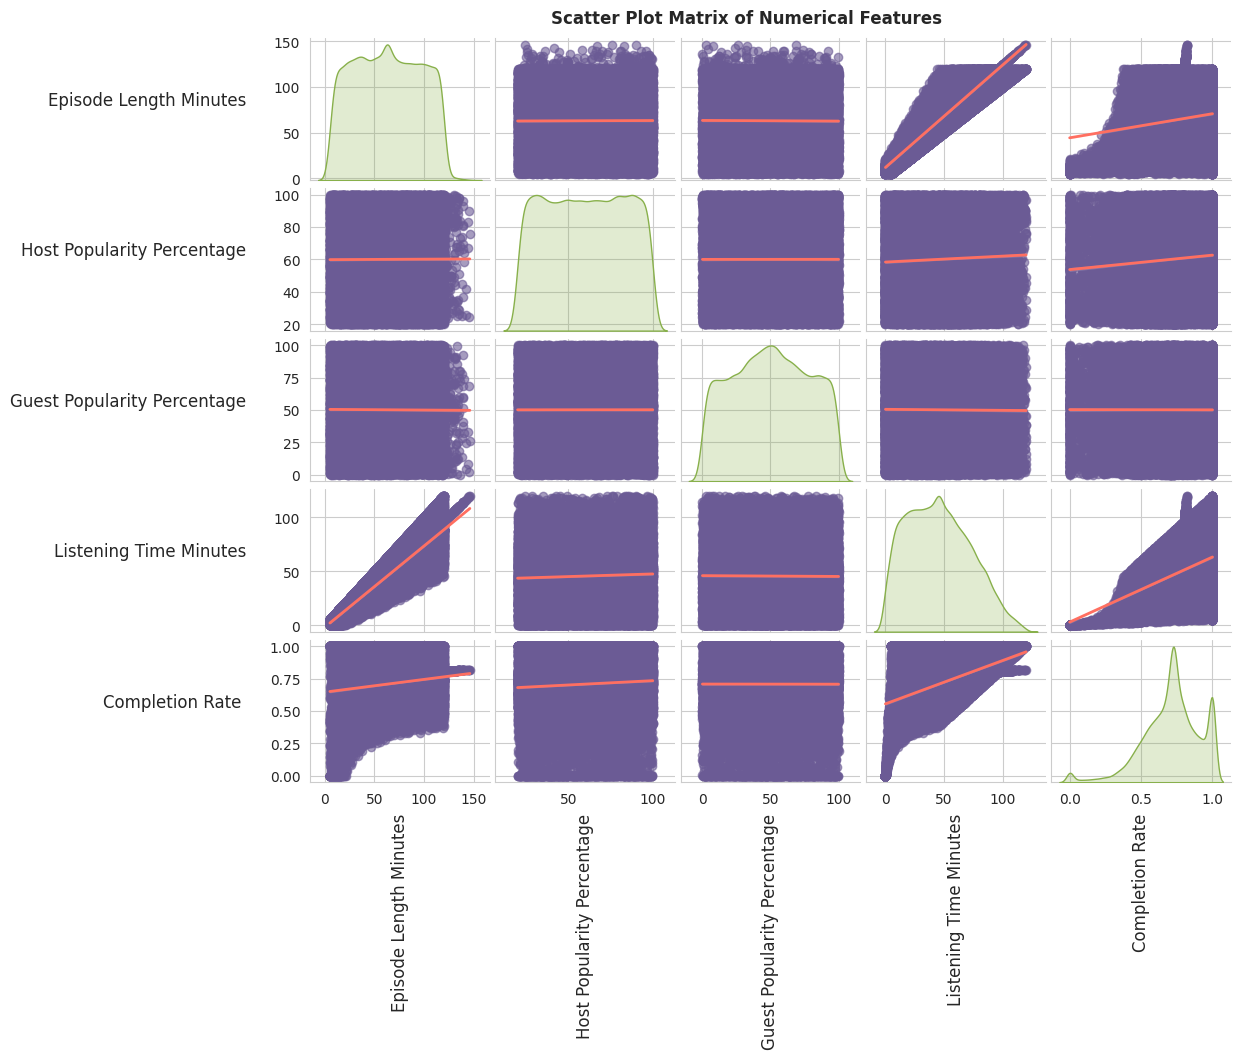

In [148]:
num_cols = [
    'episode_length_minutes',
    'host_popularity_percentage',
    'guest_popularity_percentage',
    'listening_time_minutes',
    'completion_rate'
]

plt.rcParams.update({
    'font.size': 10,
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

g = sns.pairplot(
    df[num_cols],
    kind='reg',
    diag_kind='kde',
    corner=False,
    plot_kws={
        'line_kws': {'color': '#FF6F61', 'linewidth': 2},
        'scatter_kws': {'alpha': 0.6, 'color': '#6B5B95'}
    },
    diag_kws={'shade': True, 'color': '#88B04B'}
)


g.fig.set_size_inches(10, 8)


g.fig.suptitle('Scatter Plot Matrix of Numerical Features',
               fontweight='bold', y=1.02)


for ax in g.axes.flatten():
    if ax:
        ax.set_xlabel(ax.get_xlabel().replace('_', ' ').title(), rotation=90, ha='center', labelpad=5)
        ax.set_ylabel(ax.get_ylabel().replace('_', ' ').title(), rotation=0, ha='right', labelpad=20)

plt.show()


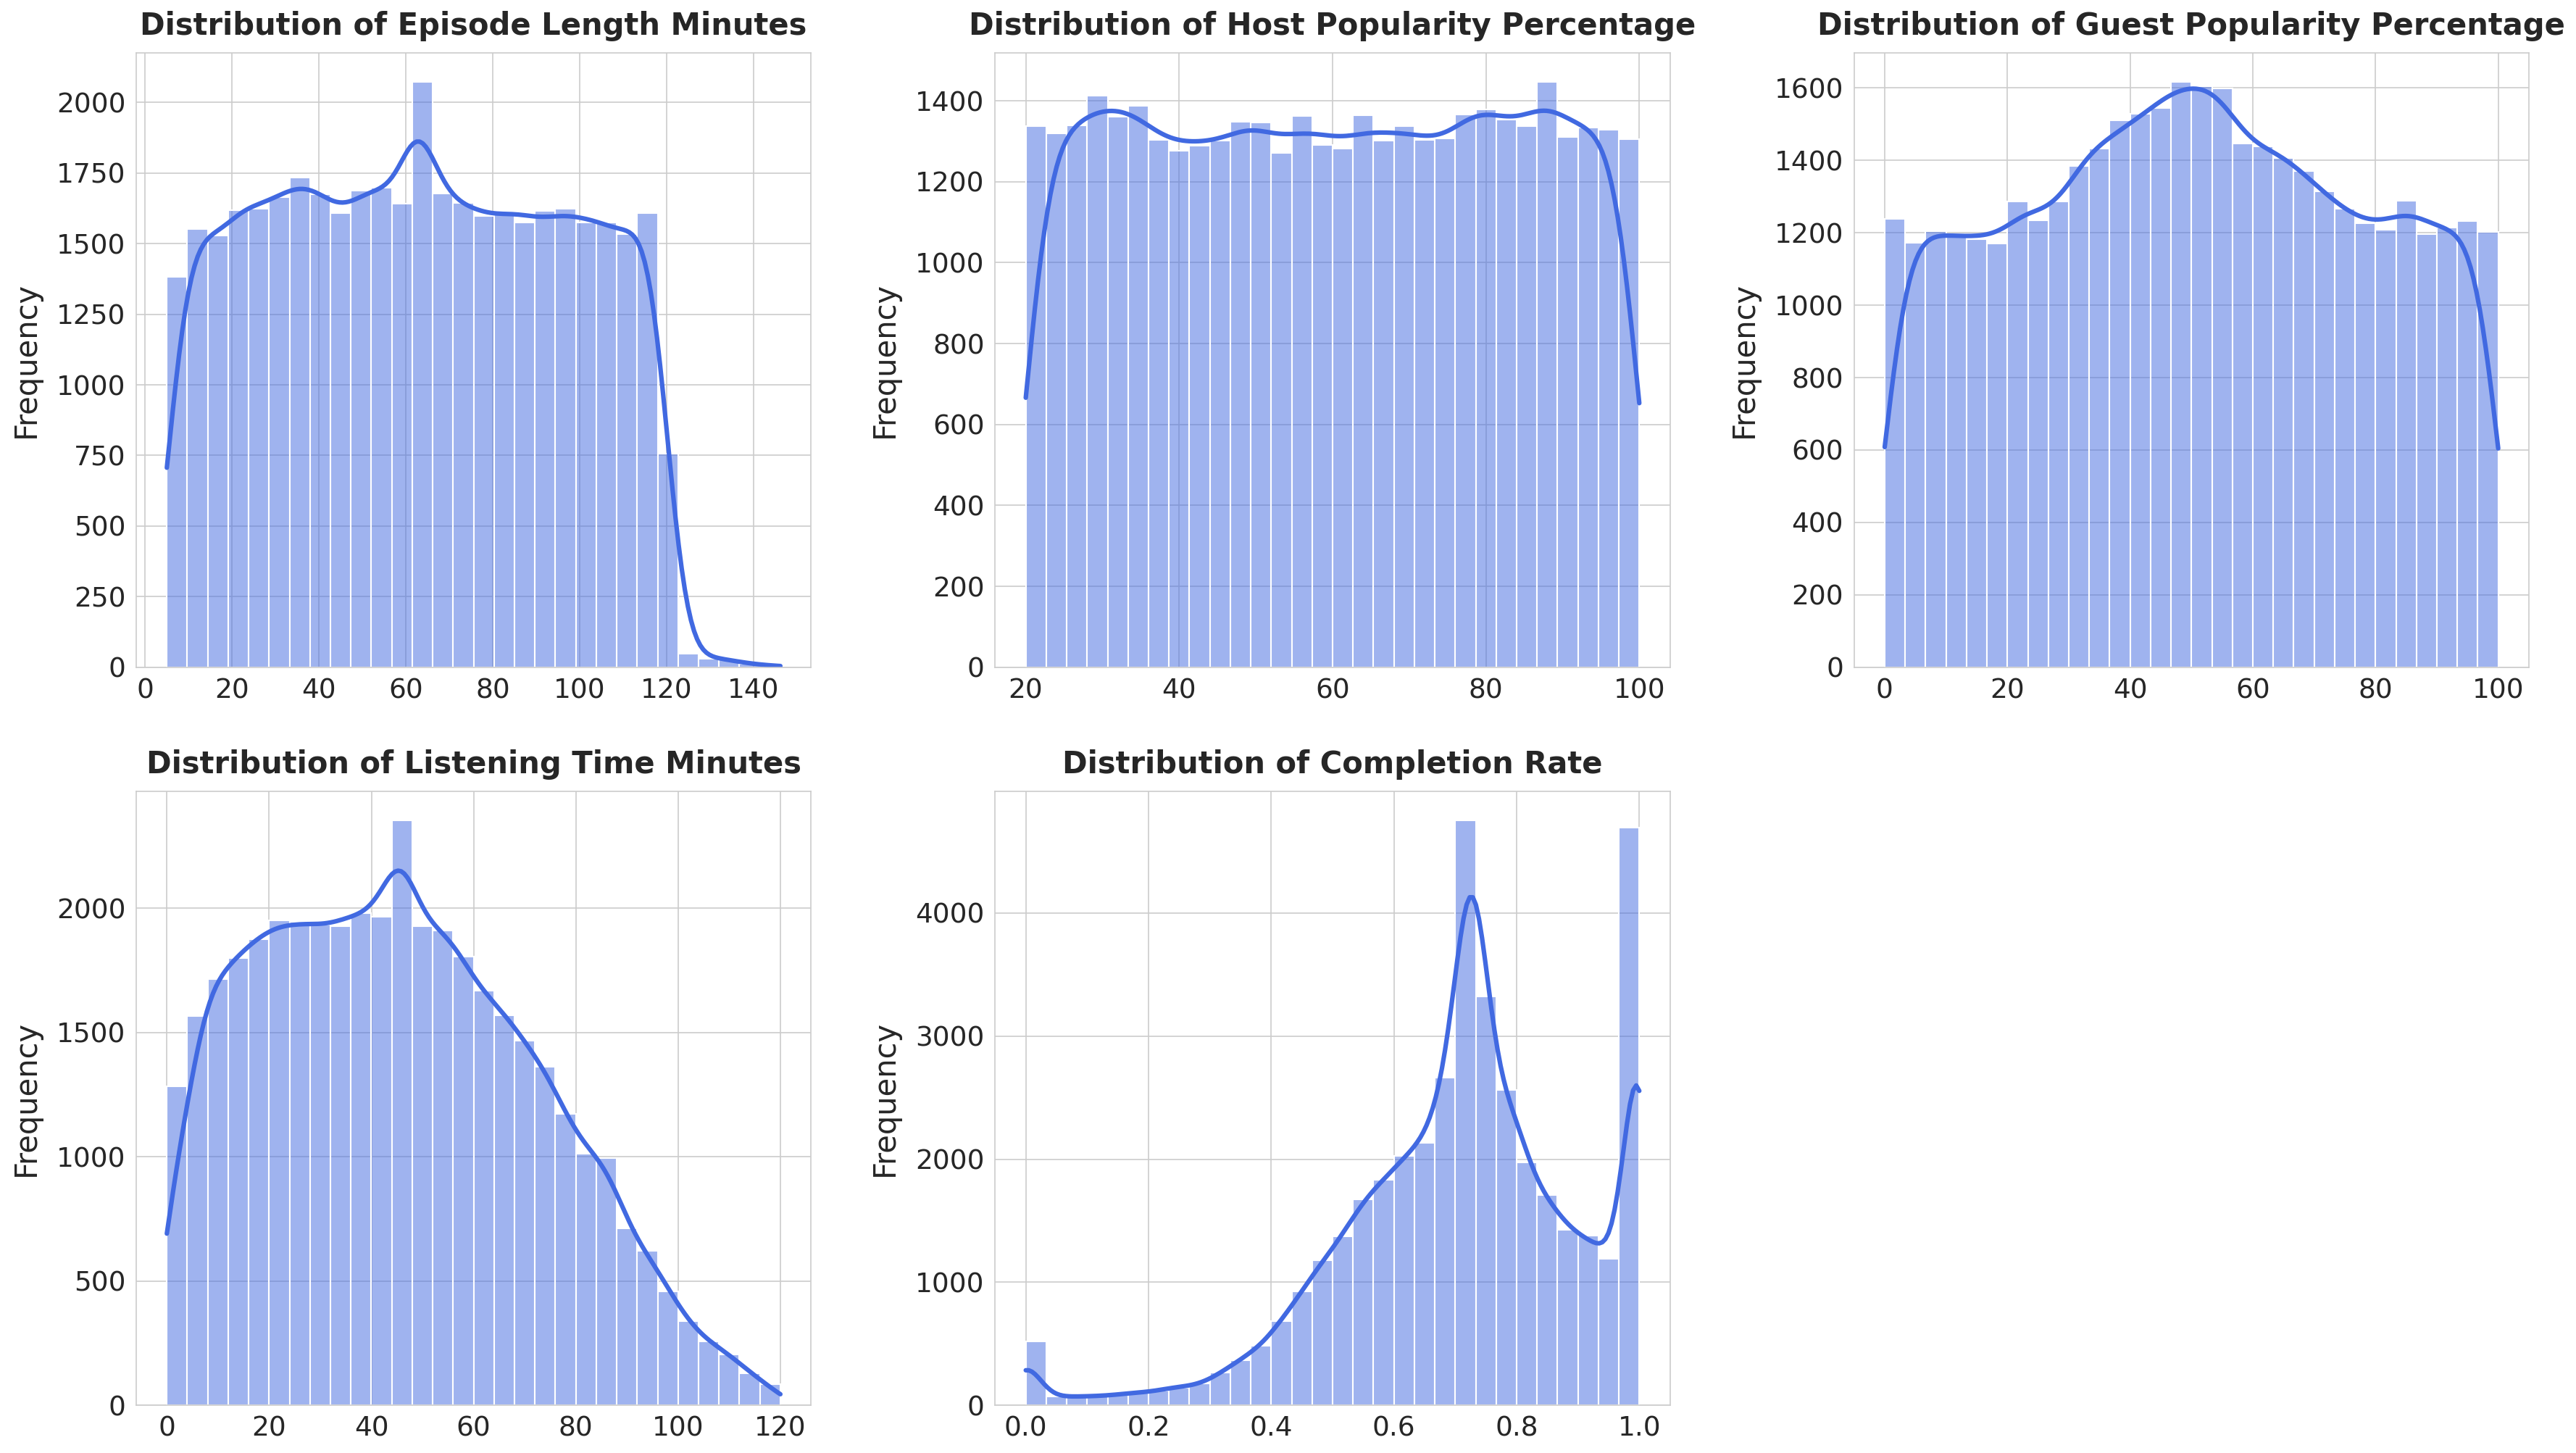

In [149]:
numerical_cols = [
    'episode_length_minutes',
    'host_popularity_percentage',
    'guest_popularity_percentage',
    'listening_time_minutes',
    'completion_rate'
]

sns.set_style("whitegrid")

TITLE_SIZE = 20
AXIS_LABEL_SIZE = 20
TICK_SIZE = 18
KDE_LINE_WIDTH = 3
N_BINS = 30

n_cols = 3
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(24, 14),
    dpi=150
)

axes = axes.flatten()

for i, col in enumerate(numerical_cols):

    sns.histplot(
        data=df,
        x=col,
        ax=axes[i],
        bins=N_BINS,
        kde=True,
        line_kws={'linewidth': KDE_LINE_WIDTH},
        color='royalblue'
    )


    axes[i].set_title(
        f'Distribution of {col.replace("_", " ").title()}',
        fontsize=TITLE_SIZE,
        fontweight='bold',
        pad=12
    )

    axes[i].set_xlabel('')
    axes[i].set_ylabel(
        'Frequency',
        fontsize=AXIS_LABEL_SIZE,
        labelpad=10
    )

    axes[i].tick_params(
        axis='x',
        labelsize=TICK_SIZE
    )
    axes[i].tick_params(
        axis='y',
        labelsize=TICK_SIZE
    )

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout(pad=3)
plt.show()


/tmp/ipython-input-341223571.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
/tmp/ipython-input-341223571.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
/tmp/ipython-input-341223571.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
/tmp/ipython-input-341223571.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
/tmp/ipython-input-341223571.py:32: FutureWarning: 

Pas

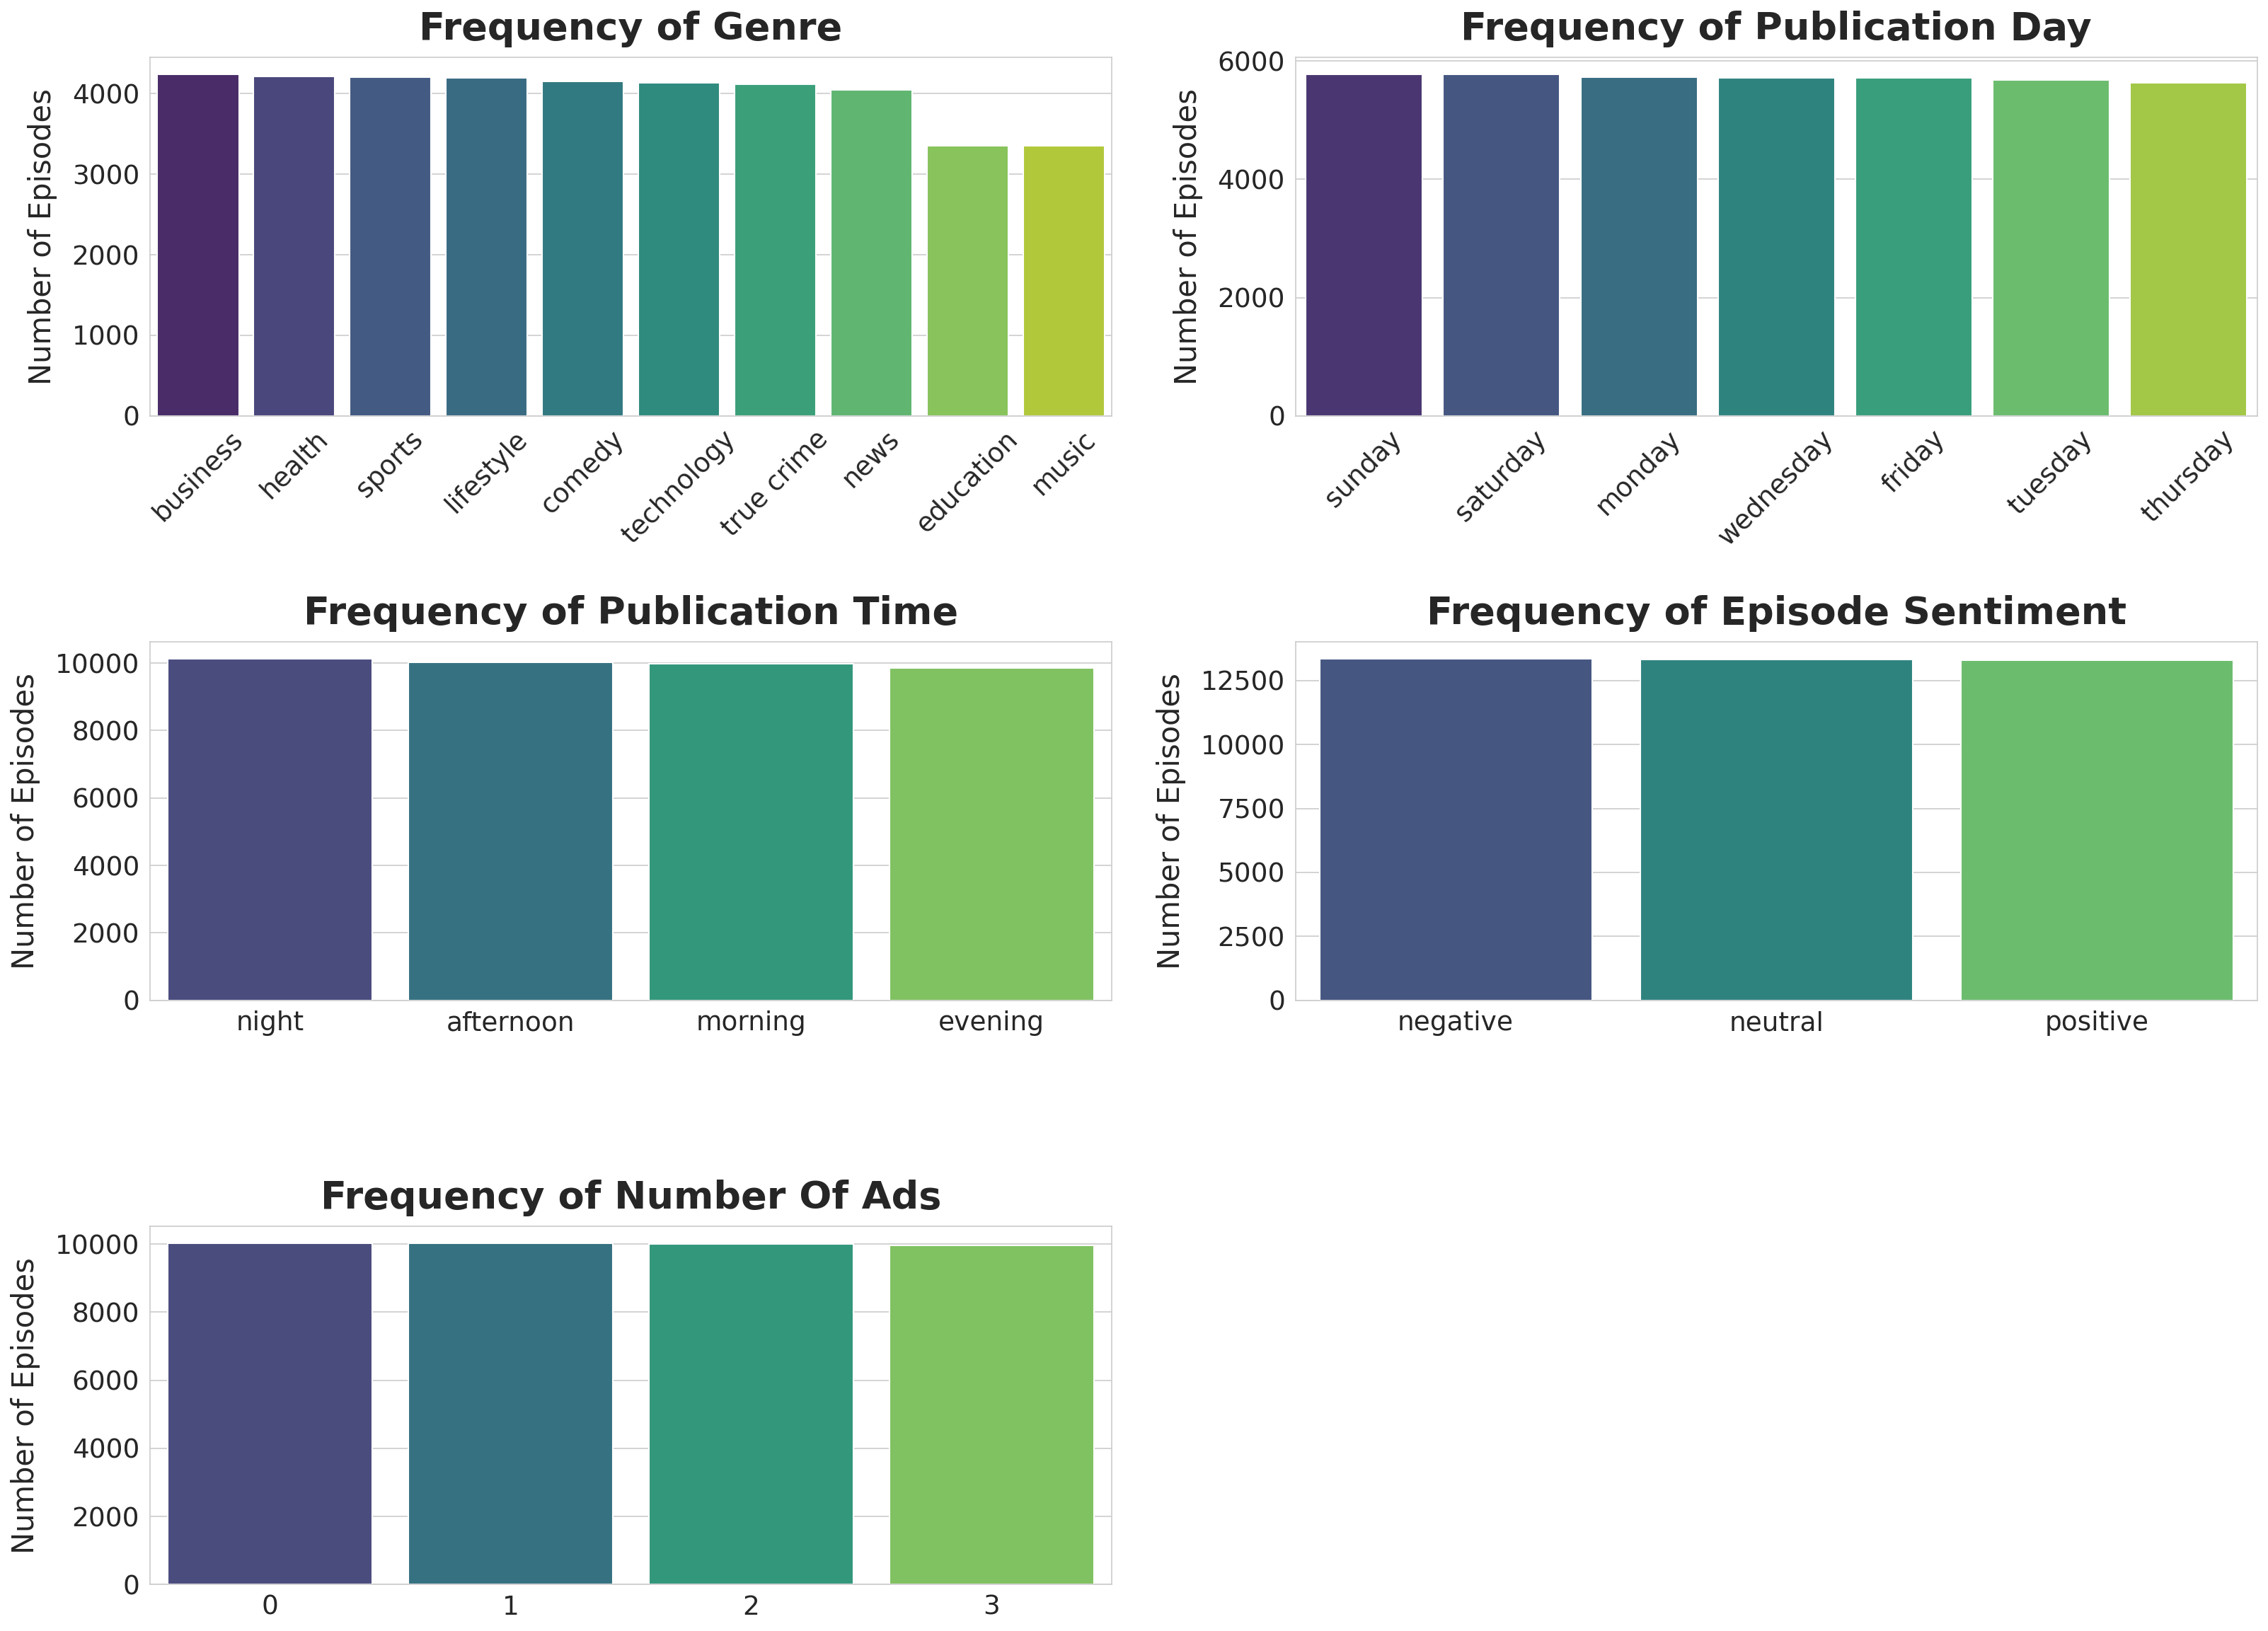

In [150]:
cat_cols = [
    'genre',
    'publication_day',
    'publication_time',
    'episode_sentiment',
    'number_of_ads'
]

sns.set_style("whitegrid")

TITLE_SIZE = 26
AXIS_LABEL_SIZE = 20
TICK_SIZE = 18
BAR_WIDTH = 0.85

n_cols = 2
n_rows = (len(cat_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(22, 16),
    dpi=150
)

axes = axes.flatten()

for i, col in enumerate(cat_cols):

    order = df[col].value_counts().index

    sns.countplot(
        data=df,
        x=col,
        order=order,
        ax=axes[i],
        palette="viridis",
        width=BAR_WIDTH
    )

    axes[i].set_title(
        f'Frequency of {col.replace("_", " ").title()}',
        fontsize=TITLE_SIZE,
        fontweight='bold',
        pad=12
    )

    axes[i].set_ylabel(
        'Number of Episodes',
        fontsize=AXIS_LABEL_SIZE,
        labelpad=10
    )
    axes[i].set_xlabel('')

    axes[i].tick_params(
        axis='x',
        labelsize=TICK_SIZE,
        rotation=45 if df[col].nunique() > 4 else 0
    )
    axes[i].tick_params(
        axis='y',
        labelsize=TICK_SIZE
    )

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout(pad=3)
plt.show()


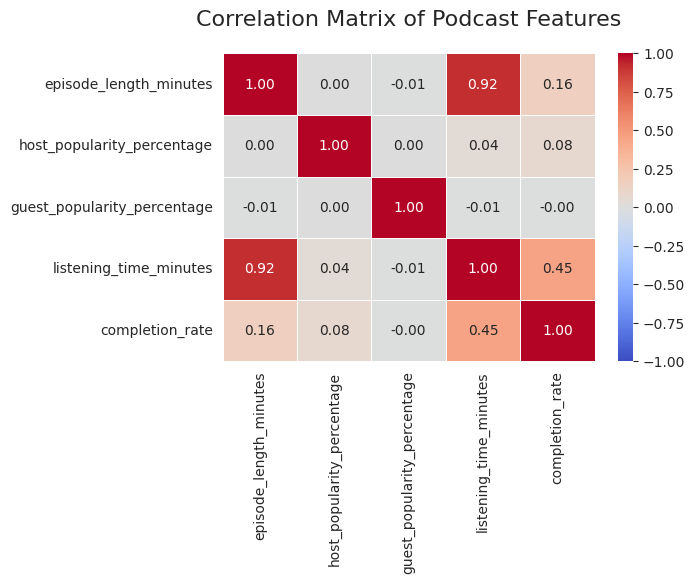

In [151]:
num_cols = [
    'episode_length_minutes',
    'host_popularity_percentage',
    'guest_popularity_percentage',
    'listening_time_minutes',
    'completion_rate'
]
corr_matrix = df[num_cols].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5,
    vmin=-1, vmax=1
)

plt.title('Correlation Matrix of Podcast Features', fontsize=16, pad=20)
plt.show()

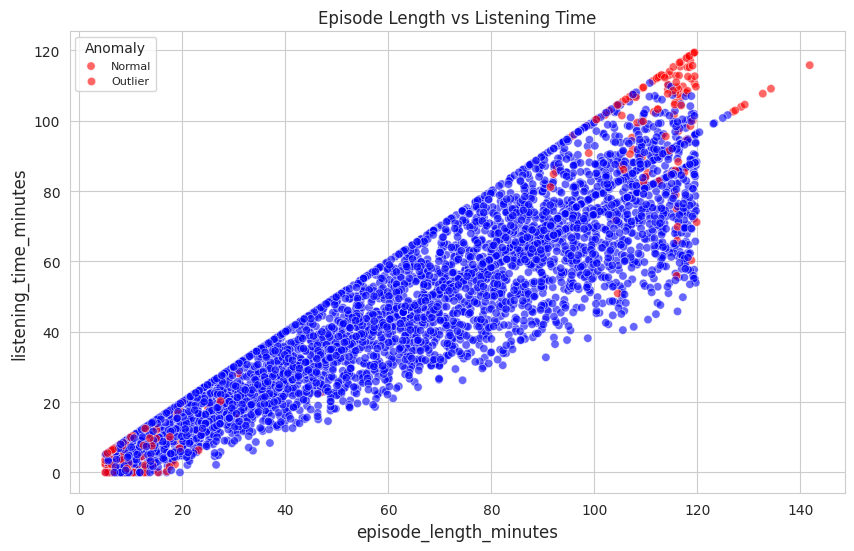

In [152]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='episode_length_minutes', y='listening_time_minutes',
                hue='iso_anomaly', palette={1: 'blue', -1: 'red'},
                alpha=0.6, data=df.sample(5000))
plt.title('Episode Length vs Listening Time')
plt.legend(title='Anomaly', labels=['Normal', 'Outlier'])
plt.show()

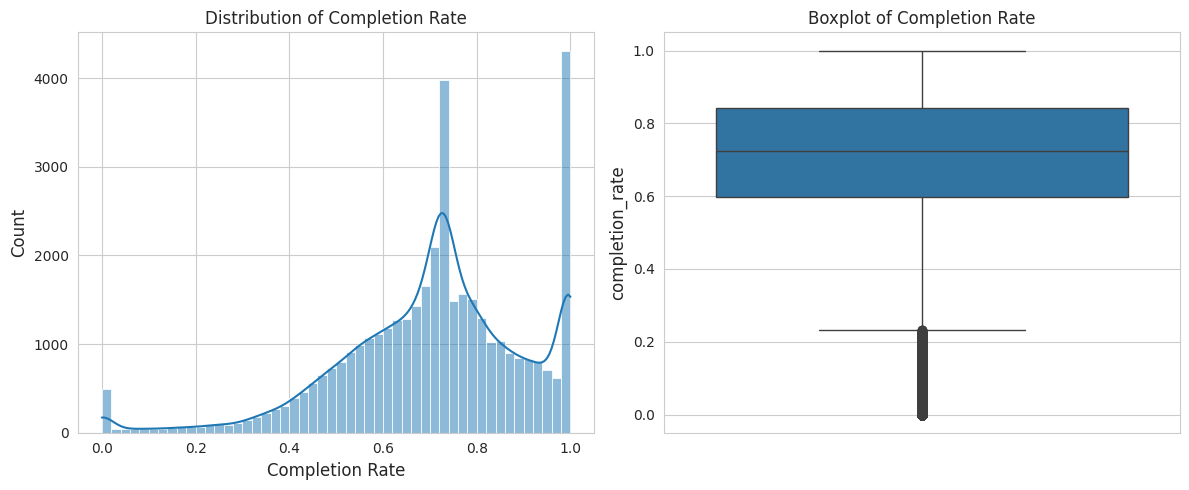

count    40000.000000
mean         0.707384
std          0.199981
min          0.000000
25%          0.597074
50%          0.724180
75%          0.840806
max          1.000000
Name: completion_rate, dtype: float64


In [153]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['completion_rate'], bins=50, kde=True)
plt.title('Distribution of Completion Rate')
plt.xlabel('Completion Rate')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['completion_rate'])
plt.title('Boxplot of Completion Rate')

plt.tight_layout()
plt.show()

print(df['completion_rate'].describe())

/tmp/ipython-input-1025060108.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='genre', y='completion_rate', data=df, order=genre_order, palette='viridis')


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'technology'),
  Text(1, 0, 'true crime'),
  Text(2, 0, 'education'),
  Text(3, 0, 'business'),
  Text(4, 0, 'music'),
  Text(5, 0, 'lifestyle'),
  Text(6, 0, 'comedy'),
  Text(7, 0, 'sports'),
  Text(8, 0, 'news'),
  Text(9, 0, 'health')])

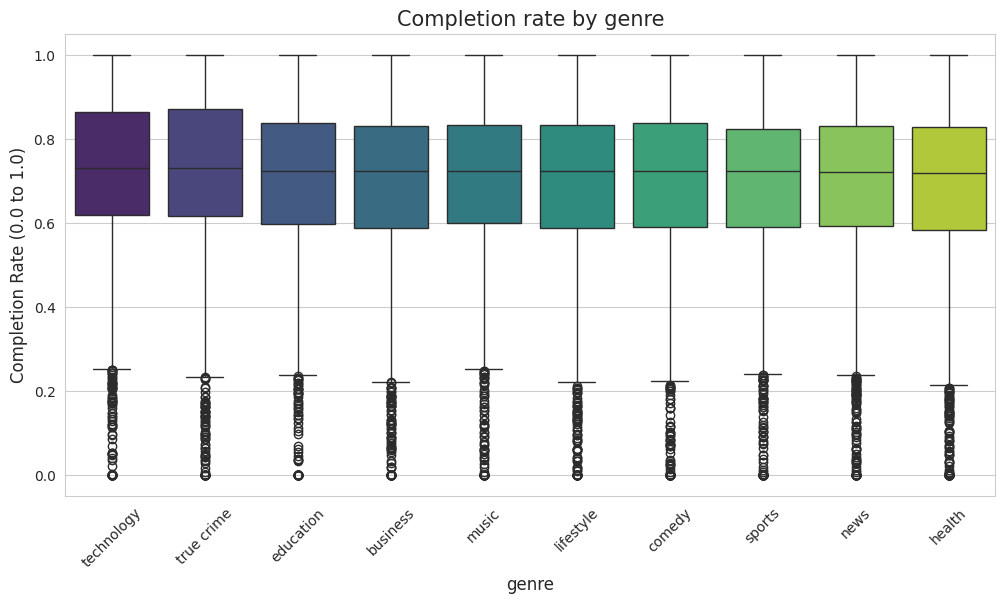

In [154]:
plt.figure(figsize=(12, 6))
genre_order = df.groupby('genre')['completion_rate'].median().sort_values(ascending=False).index
sns.boxplot(x='genre', y='completion_rate', data=df, order=genre_order, palette='viridis')
plt.title('Completion rate by genre', fontsize=15)
plt.ylabel('Completion Rate (0.0 to 1.0)')
plt.xticks(rotation=45)

/tmp/ipython-input-1483541384.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='number_of_ads', y='completion_rate', data=df, palette="husl")


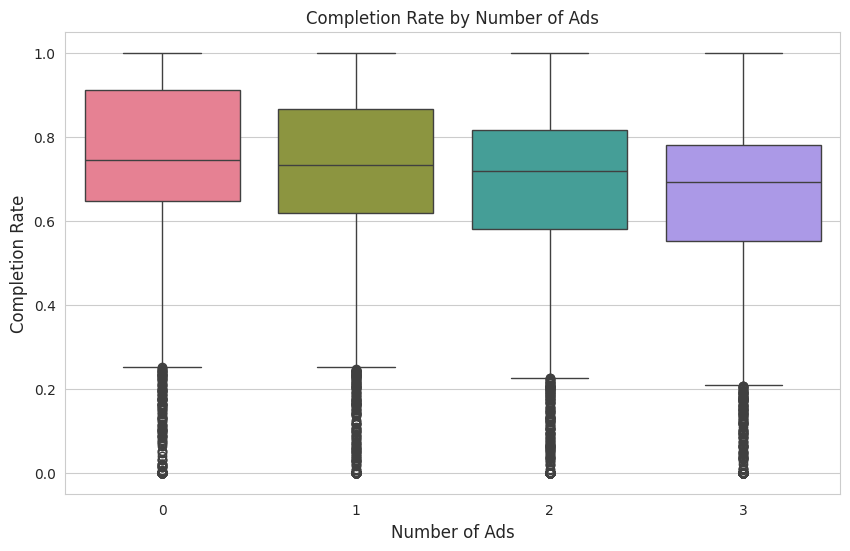

                   mean  count       std
number_of_ads                           
0              0.749338  10028  0.198301
1              0.725397  10015  0.197936
2              0.691485  10002  0.198766
3              0.662974   9955  0.194057


In [155]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='number_of_ads', y='completion_rate', data=df, palette="husl")
plt.title('Completion Rate by Number of Ads')
plt.ylabel('Completion Rate')
plt.xlabel('Number of Ads')
plt.show()

print(df.groupby('number_of_ads')['completion_rate'].agg(['mean', 'count', 'std']))

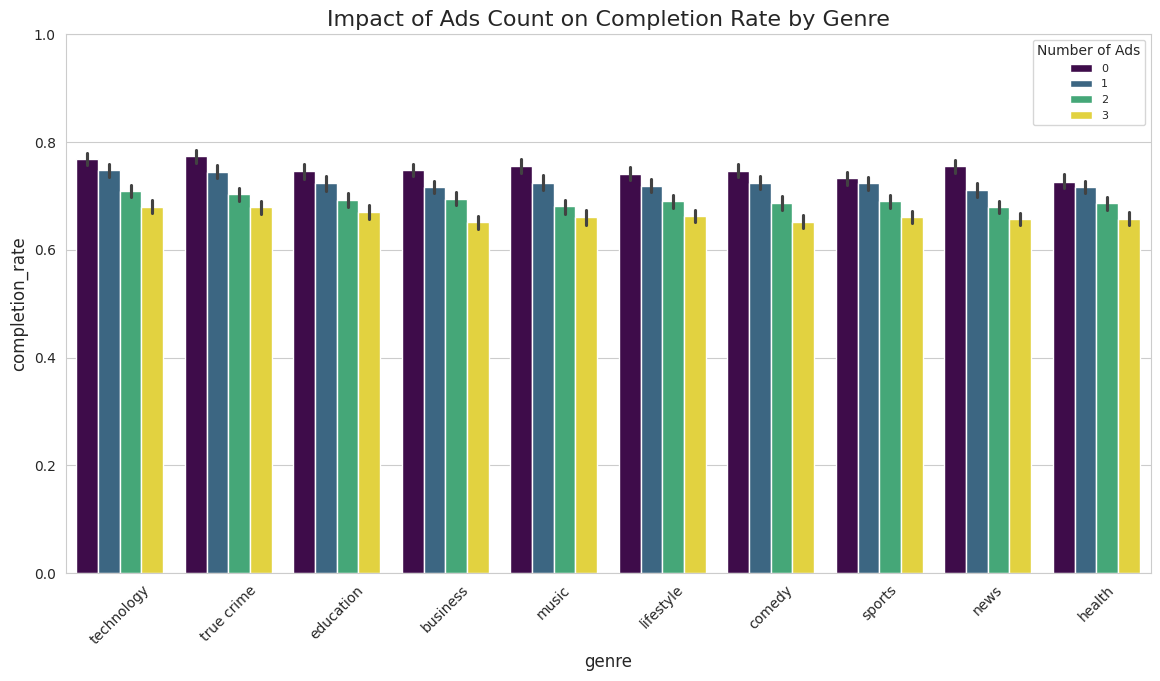

In [156]:
plt.figure(figsize=(14, 7))
order = df.groupby('genre')['completion_rate'].median().sort_values(ascending=False).index
sns.barplot(x='genre', y='completion_rate', hue='number_of_ads', data=df, order=order, palette="viridis")
plt.title('Impact of Ads Count on Completion Rate by Genre', fontsize=16)
plt.xticks(rotation=45)
plt.legend(title='Number of Ads')
plt.ylim(0, 1)
plt.show()

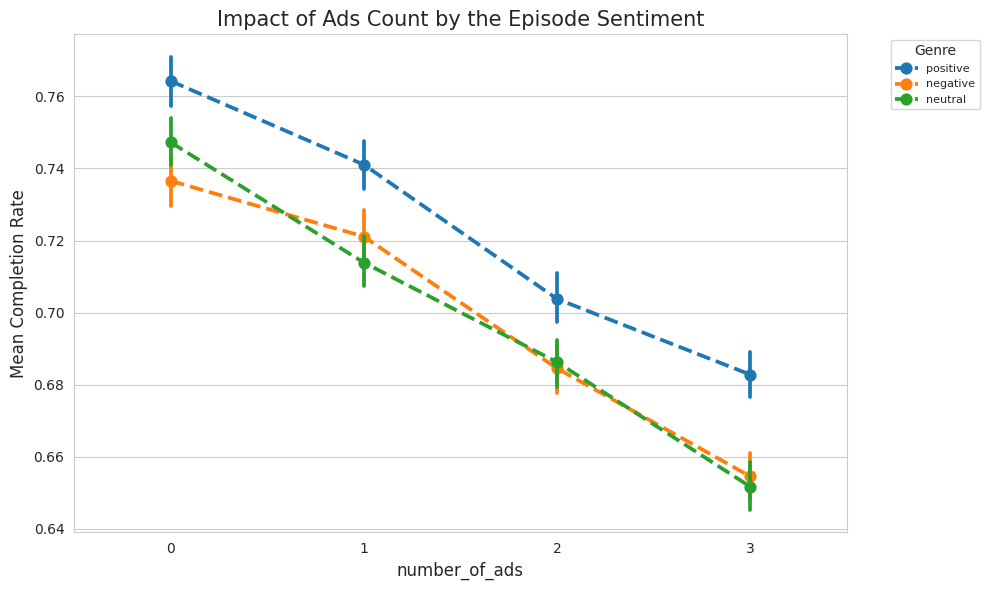

In [157]:
plt.figure(figsize=(10, 6))
sns.pointplot(x='number_of_ads', y='completion_rate', hue='episode_sentiment', data=df, markers='o', linestyles='--')
plt.title('Impact of Ads Count by the Episode Sentiment', fontsize=15)
plt.ylabel('Mean Completion Rate')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Genre')
plt.tight_layout()

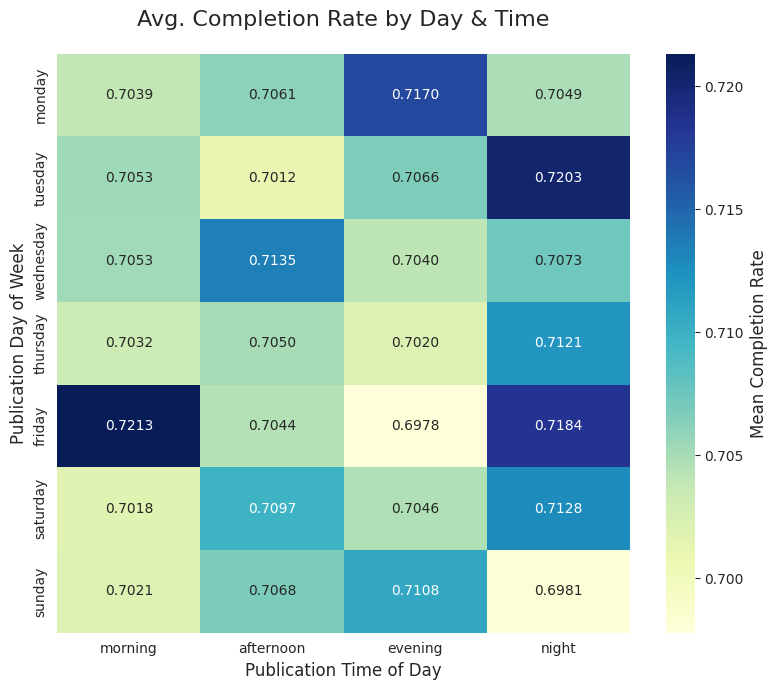

In [158]:
days_order = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
times_order = ['morning', 'afternoon', 'evening', 'night']

pivot_table = df.pivot_table(
    values='completion_rate',
    index='publication_day',
    columns='publication_time',
    aggfunc='mean'
)

pivot_table = pivot_table.reindex(index=days_order, columns=times_order)

plt.figure(figsize=(8, 7))
sns.heatmap(
    pivot_table,
    annot=True,
    cmap='YlGnBu',
    fmt='.4f',
    cbar_kws={'label': 'Mean Completion Rate'},
    annot_kws={"size": 10}
)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Avg. Completion Rate by Day & Time', fontsize=16, pad=20)
plt.xlabel('Publication Time of Day', fontsize=12)
plt.ylabel('Publication Day of Week', fontsize=12)
plt.tight_layout()

plt.show()

/tmp/ipython-input-464738403.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='length_category', y='completion_rate', data=df, palette="viridis")


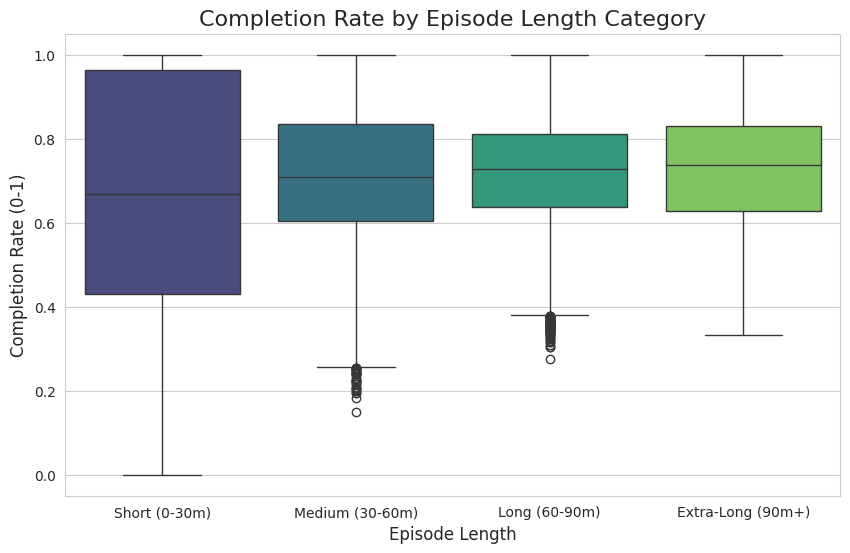

In [159]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='length_category', y='completion_rate', data=df, palette="viridis")
plt.title('Completion Rate by Episode Length Category', fontsize=16)
plt.ylabel('Completion Rate (0-1)')
plt.xlabel('Episode Length')
plt.show()


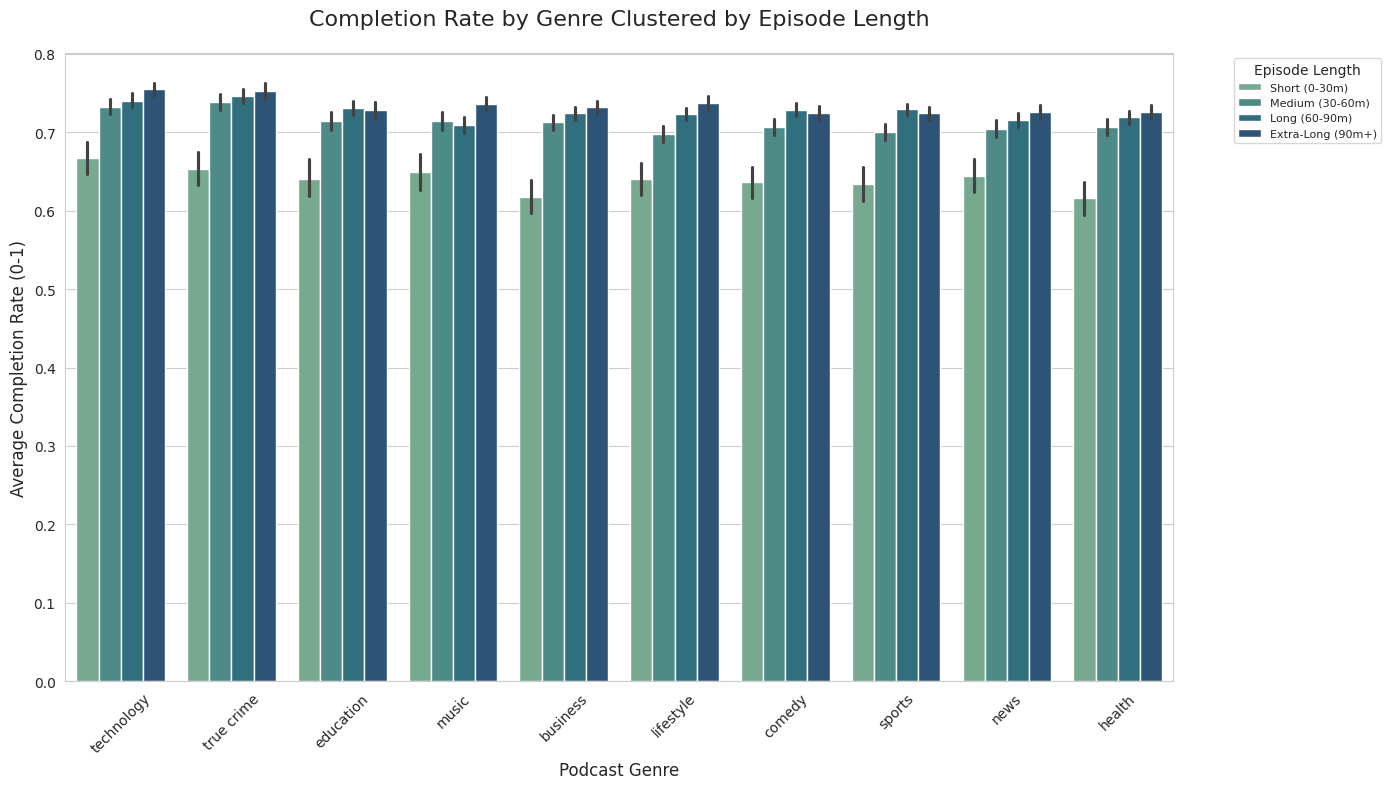

In [160]:
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

genre_order = df.groupby('genre')['completion_rate'].mean().sort_values(ascending=False).index

sns.barplot(
    data=df,
    x='genre',
    y='completion_rate',
    hue='length_category',
    order=genre_order,
    palette="crest",

)

plt.title('Completion Rate by Genre Clustered by Episode Length', fontsize=16, pad=20)
plt.ylabel('Average Completion Rate (0-1)', fontsize=12)
plt.xlabel('Podcast Genre', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Episode Length', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

/tmp/ipython-input-305539143.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


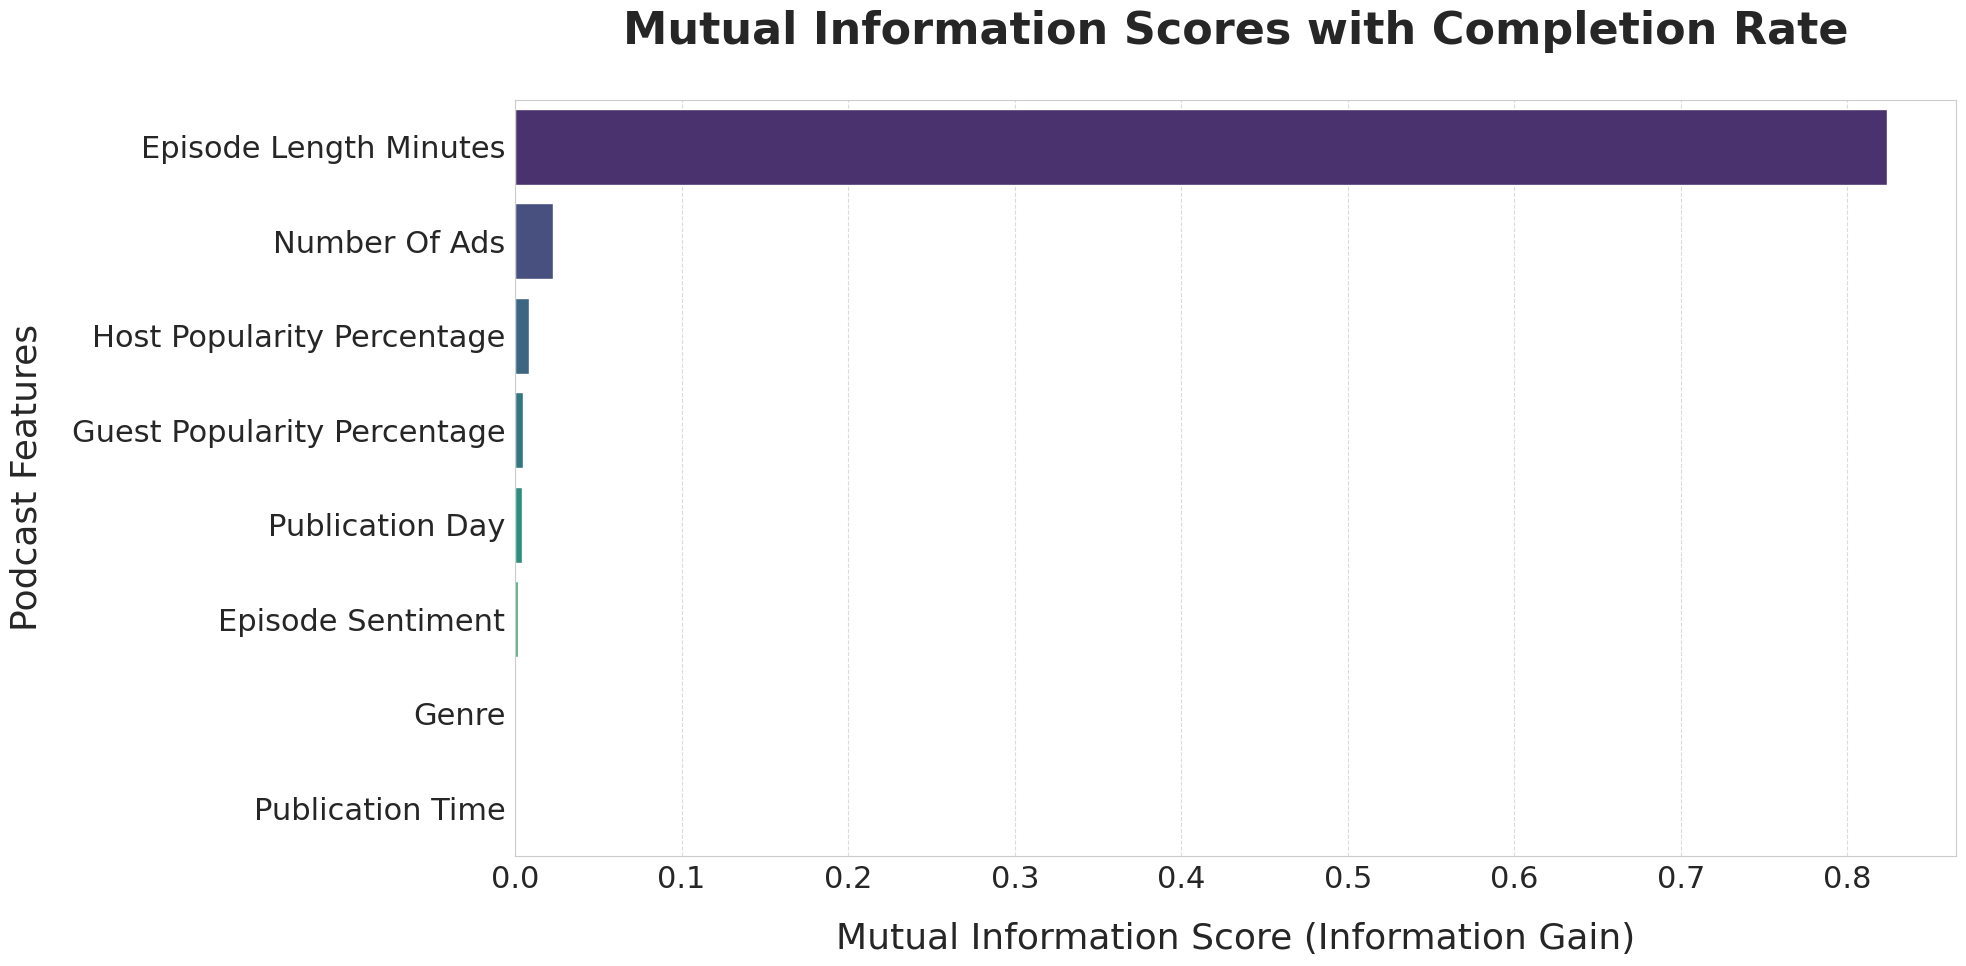

                       Feature  MI_Score
0       episode_length_minutes  0.823969
3                number_of_ads  0.022776
1   host_popularity_percentage  0.008292
2  guest_popularity_percentage  0.004759
5              publication_day  0.003837
7            episode_sentiment  0.001992
4                        genre  0.000000
6             publication_time  0.000000


In [161]:
num_features = [
    'episode_length_minutes',
    'host_popularity_percentage',
    'guest_popularity_percentage',
    'number_of_ads'
]

cat_features = [
    'genre',
    'publication_day',
    'publication_time',
    'episode_sentiment'
]

X = df[num_features + cat_features].copy()
y = df['completion_rate']


label_encoders = {}

for col in cat_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

discrete_mask = [
    col in ['number_of_ads'] + cat_features
    for col in X.columns
]

mi_scores = mutual_info_regression(
    X,
    y,
    discrete_features=discrete_mask,
    random_state=42
)


mi_df = pd.DataFrame({
    'Feature': X.columns,
    'MI_Score': mi_scores
}).sort_values(by='MI_Score', ascending=False)

plt.rcParams.update({
    'font.size': 18,
    'axes.titlesize': 32,
    'axes.labelsize': 26,
    'xtick.labelsize': 22,
    'ytick.labelsize': 22
})

plt.figure(figsize=(20, 10))

sns.barplot(
    x='MI_Score',
    y='Feature',
    data=mi_df,
    palette='viridis'
)

plt.yticks(
    ticks=range(len(mi_df)),
    labels=[f.replace('_', ' ').title() for f in mi_df['Feature']]
)

plt.title(
    'Mutual Information Scores with Completion Rate',
    fontweight='bold',
    pad=40
)

plt.xlabel('Mutual Information Score (Information Gain)', labelpad=20)
plt.ylabel('Podcast Features', labelpad=20)

plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('mutual_information_scores.png', dpi=300)
plt.show()

print(mi_df)
